# Use CellProfiler Features Extracted to Construct a knn Network

## Import data and split into training/test set

In [109]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv(r"..\data\processed\cellprofiler_data.csv")
data = raw_data.drop(["Phenotype", "ImageNumber"], axis=1)
labels = raw_data["Phenotype"]
data = data.to_numpy()
labels = labels.to_numpy()
phenotype = {"alveolar": 0,
             "marrow": 1,
             "monocyte": 2}
labels = [phenotype[label] for label in labels]

from random import shuffle
train_index = [[] for _ in range(len(phenotype))] 
test_index = [[] for _ in range(len(phenotype))]

[train_index[labels[i]].append(i) for i in range(len(labels))]

for i in range(len(train_index)):
    tmp = train_index[i]
    shuffle(tmp)

    test_len = int(len(tmp)/5)
    test_index[i].extend(tmp[:test_len])
    train_index[i] = tmp[test_len:]

tmp = []
[tmp.extend(inds) for inds in train_index]
train_index = tmp

train_samples = np.stack([data[ind] for ind in train_index])
train_labels = np.stack([labels[ind] for ind in train_index])

tmp = []
[tmp.extend(inds) for inds in test_index]
test_index = tmp

test_samples = np.stack([data[ind] for ind in test_index])
test_labels = np.stack([labels[ind] for ind in test_index])

In [103]:
def generate_confusion_matrix(outputs, labels):
    num_classes = len(outputs[0][0])
    print(num_classes)
    confusion_matrix = np.zeros((num_classes, num_classes))

    for t, p in zip(labels, outputs):
            confusion_matrix[int(t), int(p)] += 1
    
    matrix = np.array(confusion_matrix)
    matrix = np.array([i/sum(i) for i in matrix])

    test_accuracy = 0
    for i in range(num_classes):
        test_accuracy += confusion_matrix[i,i]
    test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

    return matrix, test_accuracy

## Use KNeighbors on chosen data

In [110]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=len(phenotype))
knn.fit(train_samples, train_labels)

out = list(knn.predict(test_samples))
correct = 0
total = len(out)
for pred, label in zip(out, test_labels):
    correct += int(pred == label)

accuracy = correct / total

print(f"accuracy of knn: {accuracy:>0.2%}")

accuracy of knn: 73.20%


In [111]:
num_classes = max(out) + 1

confusion_matrix = np.zeros((num_classes, num_classes))

for t, p in zip(out, test_labels):
    confusion_matrix[int(t), int(p)] += 1

matrix = np.array(confusion_matrix)
matrix = np.array([i/sum(i) for i in matrix])

test_accuracy = 0
for i in range(num_classes):
    test_accuracy += confusion_matrix[i,i]
test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

print(matrix)

[[0.75149105 0.055666   0.19284294]
 [0.01682692 0.78605769 0.19711538]
 [0.23121387 0.1300578  0.63872832]]


## PCA of data

Explained variation per principal component: [6.15497121e-01 3.11362228e-01 1.89722232e-02 1.15910725e-02
 1.00501785e-02 7.82423768e-03 5.12302547e-03 4.09017685e-03
 3.28899960e-03 2.53827793e-03 1.41474380e-03 1.27393679e-03
 9.95780327e-04 8.96536292e-04 7.61210899e-04 6.04260207e-04
 4.72562847e-04 3.98281015e-04 3.52450384e-04 2.76090025e-04
 2.34682176e-04 2.09747096e-04 2.03390657e-04 1.85854499e-04
 1.69480088e-04 1.49842108e-04 1.20948395e-04 9.38467389e-05
 9.23083460e-05 8.35407261e-05 6.42168744e-05 6.15119311e-05
 5.92102859e-05 5.55726905e-05 5.38353922e-05 5.00312846e-05
 4.20320032e-05 3.82147495e-05 3.15322968e-05 2.64990755e-05
 2.24695002e-05 2.17753120e-05 1.94465021e-05 1.56757018e-05
 1.15044813e-05 1.04854247e-05 8.03663856e-06 7.42515576e-06
 6.02973768e-06 5.89141496e-06 5.54160386e-06 5.08574281e-06
 4.83044421e-06 4.38846274e-06 4.08401227e-06 3.65205034e-06
 3.38883403e-06 2.78612405e-06 2.51827662e-06 2.33664542e-06
 2.19221281e-06 2.01400925e-06 1.7525981

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

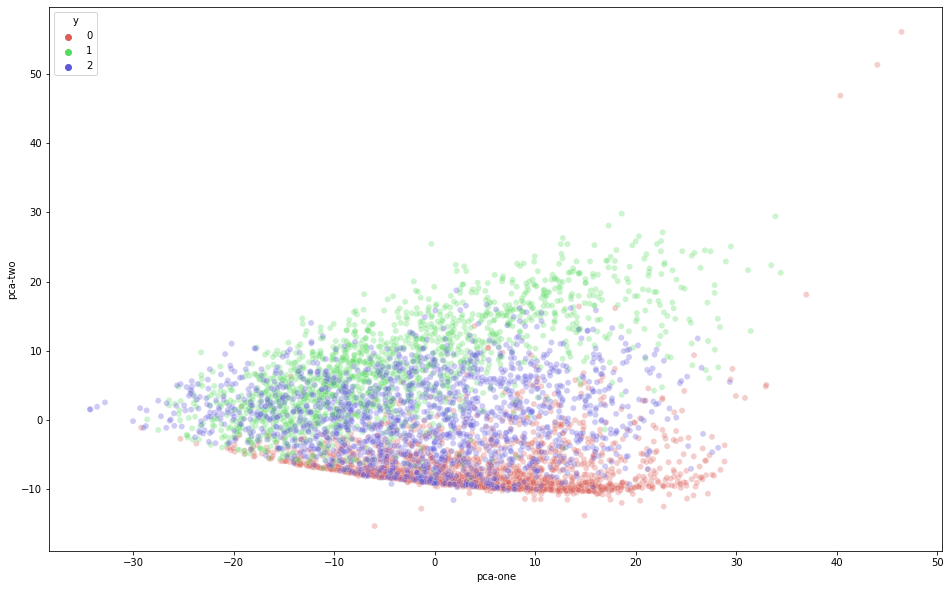

In [123]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
std_data = sc.fit_transform(train_samples)

num_comp = 5

#pca = PCA(n_components=num_comp)
pca = PCA()

pca_result = pca.fit_transform(std_data)

graph_data = pd.DataFrame()
graph_data['pca-one'] = pca_result[:,0]
graph_data['pca-two'] = pca_result[:,1] 
graph_data['pca-three'] = pca_result[:,2]
graph_data['y'] = train_labels

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=graph_data,
    legend="full",
    alpha=0.3
)


In [87]:
knn = KNeighborsClassifier(n_neighbors=len(phenotype))
knn.fit(train_samples, train_labels)

out = list(knn.predict(test_samples))
correct = 0
total = len(out)
for pred, label in zip(out, test_labels):
    correct += int(pred == label)

accuracy = correct / total

print(f"accuracy of knn: {accuracy:>0.2%}")

accuracy of pca 3 component: 56.52%


In [88]:
pca.transform(test_samples_std)

array([[-6.22374753, -7.66101008,  1.15074631],
       [15.72322841, -9.12820305, -2.52404362],
       [-1.11142201, -6.3927136 , -0.79113564],
       ...,
       [-8.30875424, -7.30334866, -0.65794231],
       [-2.15718862, -6.98174905, -2.41037281],
       [ 1.4024568 ,  0.99678436, -0.18712975]])

In [89]:

confusion_matrix = np.zeros((num_classes, num_classes))

for t, p in zip(out, test_labels):
    confusion_matrix[int(t), int(p)] += 1

matrix = np.array(confusion_matrix)
matrix = np.array([i/sum(i) for i in matrix])

test_accuracy = 0
for i in range(num_classes):
    test_accuracy += confusion_matrix[i,i]
test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

print(matrix)

[[0.74896266 0.0560166  0.19502075]
 [0.04076739 0.76978417 0.18944844]
 [0.23770492 0.1420765  0.62021858]]


## T-SNE of Data

In [90]:
from sklearn.manifold import TSNE

embedded = TSNE(n_components=2).fit_transform(data)


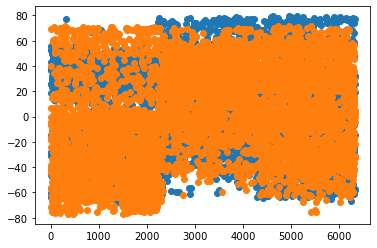

In [91]:

plt.plot(embedded, 'o')